In [1]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
import sys
from datetime import datetime
sys.path.append("../")
sys.path.append("../../")
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True, local_files_only = False)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer.eos_token_id).to(device)

/opt/conda/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
symbols_important = ["He", "She"]
symbols_dummy = ["died.", 
                 "died yesterday.",
                 "died yesterday in.", 
                 "died yesterday in a.", 
                 "died yesterday in a very.", 
                 "died yesterday in a very sad.", 
                 "died yesterday in a very sad way.", 
                 "died yesterday in a very sad way due.", 
                 "died yesterday in a very sad way due to.", 
                 "died yesterday in a very sad way due to a.",
                 "died yesterday in a very sad way due to a heart.", 
                 "died yesterday in a very sad way due to a heart attack."]

In [3]:
print(tokenizer.encode(symbols_important))
print(symbols_important)

[679, 1375]
['He', 'She']


In [4]:
for symbols in symbols_dummy:
    tokens = tokenizer.encode(symbols)
    print(f"Symbols: {symbols}")
    print(f"Tokens: {tokens}")

Symbols: died.
Tokens: [3724, 13]
Symbols: died yesterday.
Tokens: [3724, 7415, 13]
Symbols: died yesterday in.
Tokens: [3724, 7415, 287, 13]
Symbols: died yesterday in a.
Tokens: [3724, 7415, 287, 257, 13]
Symbols: died yesterday in a very.
Tokens: [3724, 7415, 287, 257, 845, 13]
Symbols: died yesterday in a very sad.
Tokens: [3724, 7415, 287, 257, 845, 6507, 13]
Symbols: died yesterday in a very sad way.
Tokens: [3724, 7415, 287, 257, 845, 6507, 835, 13]
Symbols: died yesterday in a very sad way due.
Tokens: [3724, 7415, 287, 257, 845, 6507, 835, 2233, 13]
Symbols: died yesterday in a very sad way due to.
Tokens: [3724, 7415, 287, 257, 845, 6507, 835, 2233, 284, 13]
Symbols: died yesterday in a very sad way due to a.
Tokens: [3724, 7415, 287, 257, 845, 6507, 835, 2233, 284, 257, 13]
Symbols: died yesterday in a very sad way due to a heart.
Tokens: [3724, 7415, 287, 257, 845, 6507, 835, 2233, 284, 257, 2612, 13]
Symbols: died yesterday in a very sad way due to a heart attack.
Tokens: 

In [5]:
prompt = tokenizer.decode(tokenizer.bos_token_id) + "The doctor was very famous."
input_ids = torch.tensor(tokenizer.encode(prompt)).reshape(1, -1).to(device)

print(input_ids)

with torch.no_grad():
    output = model(input_ids)
    logits = output.logits[:, -1, :]
    probs = torch.softmax(logits, dim=-1)[0]

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


tensor([[50256,   383,  6253,   373,   845,  5863,    13]])


In [6]:
word_probs = {}
print(symbols_important)
symbols_important_ids = [tokenizer.encode(sym) for sym in symbols_important]
print(symbols_important_ids)
for i in symbols_important_ids :
    print(i)
    
    word_prob = probs[i]
    word_probs[tokenizer.decode(i).replace(" ","")] = word_prob.item()

    
normalized_word_probs_he_she = {}
total = sum(word_probs.values())
for word in word_probs:
    normalized_word_probs_he_she[word] = word_probs[word] / total

normalized_word_probs_he_she

['He', 'She']
[[679], [1375]]
[679]
[1375]


{'He': 0.9474213481974543, 'She': 0.0525786518025457}

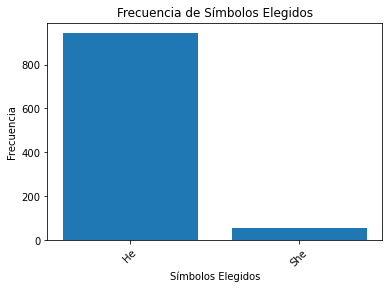

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

choices = []
num_choices = 1000
for _ in range(num_choices):
    symbol_choosen = np.random.choice(list(normalized_word_probs_he_she.keys()), 
                                       p=list(normalized_word_probs_he_she.values()))
    choices.append(symbol_choosen)

frequency = Counter(choices)

plt.bar(frequency.keys(), frequency.values())
plt.xlabel('Símbolos Elegidos')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Símbolos Elegidos')
plt.xticks(rotation=45)
plt.show()

In [8]:
symbol_choosen = np.random.choice(list(normalized_word_probs_he_she.keys()), 
                                       p=list(normalized_word_probs_he_she.values()))

prompt_v2 = tokenizer.decode(tokenizer.bos_token_id) + "The doctor was very famous. " + symbol_choosen
print(prompt_v2)

prompt = tokenizer.decode(tokenizer.bos_token_id) + "The doctor was very famous." + symbol_choosen
print(prompt)
input_ids_v2 = torch.tensor(tokenizer.encode(prompt_v2)).reshape(1, -1).to(device)
print(input_ids_v2)

#we gonna use this one now
input_ids = torch.tensor(tokenizer.encode(prompt)).reshape(1, -1).to(device)
print(input_ids)


<|endoftext|>The doctor was very famous. He
<|endoftext|>The doctor was very famous.He
tensor([[50256,   383,  6253,   373,   845,  5863,    13,   679]])
tensor([[50256,   383,  6253,   373,   845,  5863,    13,  1544]])


In [9]:
with torch.no_grad():
    output = model(input_ids)
    logits = output.logits[:, -1, :]
    probs = torch.softmax(logits, dim=-1)[0]

In [10]:
split_lists = [sentence.split() for sentence in symbols_dummy]

for lst in split_lists:
    print(lst)

['died.']
['died', 'yesterday.']
['died', 'yesterday', 'in.']
['died', 'yesterday', 'in', 'a.']
['died', 'yesterday', 'in', 'a', 'very.']
['died', 'yesterday', 'in', 'a', 'very', 'sad.']
['died', 'yesterday', 'in', 'a', 'very', 'sad', 'way.']
['died', 'yesterday', 'in', 'a', 'very', 'sad', 'way', 'due.']
['died', 'yesterday', 'in', 'a', 'very', 'sad', 'way', 'due', 'to.']
['died', 'yesterday', 'in', 'a', 'very', 'sad', 'way', 'due', 'to', 'a.']
['died', 'yesterday', 'in', 'a', 'very', 'sad', 'way', 'due', 'to', 'a', 'heart.']
['died', 'yesterday', 'in', 'a', 'very', 'sad', 'way', 'due', 'to', 'a', 'heart', 'attack.']


In [11]:
word_probs.clear()

print(split_lists[0])
sentence = split_lists[0]
symbols_dummy_ids = [tokenizer.encode(sym) for sym in sentence]
symbols_dummy_ids = [[token_id] for sublist in symbols_dummy_ids for token_id in sublist]
print(symbols_dummy_ids)
for i in symbols_dummy_ids :
    print(i)
    
    word_prob = probs[i]
    word_probs[tokenizer.decode(i).replace(" ","")] = word_prob.item()
    
normalized_word_probs_dummy = {}
total = sum(word_probs.values())
for word in word_probs:
    normalized_word_probs_dummy[word] = word_probs[word] / total

normalized_word_probs_dummy

['died.']
[[3724], [13]]
[3724]
[13]


{'died': 0.9881285521100452, '.': 0.011871447889954789}

In [12]:

prompt = tokenizer.decode(tokenizer.bos_token_id) + "The doctor was very famous." + symbol_choosen + " " +sentence[0]
prompt



'<|endoftext|>The doctor was very famous.He died.'

In [13]:
word_probs.clear()


print(split_lists[1])
sentence = split_lists[1]
symbols_dummy_ids = [tokenizer.encode(sym) for sym in sentence]
symbols_dummy_ids = [[token_id] for sublist in symbols_dummy_ids for token_id in sublist]
print(symbols_dummy_ids)
for i in symbols_dummy_ids :
    print(i)
    
    word_prob = probs[i]
    word_probs[tokenizer.decode(i).replace(" ","")] = word_prob.item()
    
normalized_word_probs_dummy = {}
total = sum(word_probs.values())
for word in word_probs:
    normalized_word_probs_dummy[word] = word_probs[word] / total

normalized_word_probs_dummy


['died', 'yesterday.']
[[3724], [7415], [13]]
[3724]
[7415]
[13]


{'died': 0.9880029857200155,
 'yesterday': 0.00012707495372092723,
 '.': 0.011869939326263573}

In [14]:
prompt = tokenizer.decode(tokenizer.bos_token_id) + "The doctor was very famous." + symbol_choosen + " " +sentence[0]


for words in sentence:
    print(words)
    symbols_dummy_ids = [tokenizer.encode(sym) for sym in sentence]
    symbols_dummy_ids = [[token_id] for sublist in symbols_dummy_ids for token_id in sublist]
    for i in symbols_dummy_ids:
        word_prob = probs[i]
        word_probs[tokenizer.decode(i).replace(" ","")] = word_prob.item()
        
    
    normalized_word_probs_dummy.clear()
    normalized_word_probs_dummy = {}
    total = sum(word_probs.values())
    for word in word_probs:
        normalized_word_probs_dummy[word] = word_probs[word] / total
        
    print(sentence)
    
        
    print(normalized_word_probs_dummy)


died
['died', 'yesterday.']
{'died': 0.9880029857200155, 'yesterday': 0.00012707495372092723, '.': 0.011869939326263573}
yesterday.
['died', 'yesterday.']
{'died': 0.9880029857200155, 'yesterday': 0.00012707495372092723, '.': 0.011869939326263573}


In [22]:
def calculate_probabilities(split_lists, index, tokenizer, model, device):
    # Tomar la lista de palabras en la posición 'index' de split_lists
    sentence = split_lists[index]
    print(f"Original sentence: {sentence}")

    # Iterar sobre la lista reduciendo el tamaño en cada paso
    for i in range(len(sentence)):
        # Limpiar word_probs para cada sublista
        word_probs.clear()

        # Usar solo las palabras desde el índice actual hasta el final
        current_sentence = sentence[i:]

        # Codificar los tokens y organizarlos en la forma [[token_id]]
        symbols_dummy_ids = [tokenizer.encode(sym) for sym in current_sentence]
        symbols_dummy_ids = [[token_id] for sublist in symbols_dummy_ids for token_id in sublist]

        print(f"Current sentence: {current_sentence}")
        print(f"Token IDs: {symbols_dummy_ids}")

        # Recalcular las probabilidades para los tokens actuales
        for token_ids in symbols_dummy_ids:
            for token in token_ids:
                word_prob = probs[token]  # Asumiendo que 'probs' ya fue calculado en el contexto del modelo
                word_probs[tokenizer.decode(token).replace(" ","")] = word_prob.item()

        # Normalizar las probabilidades
        normalized_word_probs_dummy = {}
        total = sum(word_probs.values())
        for word in word_probs:
            normalized_word_probs_dummy[word] = word_probs[word] / total

        print(f"Normalized probabilities for '{' '.join(current_sentence)}': {normalized_word_probs_dummy}")
    
    return normalized_word_probs_dummy

# Ejemplo de uso:
normalized_word_probs_dummy = calculate_probabilities(split_lists, 1, tokenizer, model, device)


Original sentence: ['died', 'yesterday.']
Current sentence: ['died', 'yesterday.']
Token IDs: [[3724], [7415], [13]]
Normalized probabilities for 'died yesterday.': {'died': 0.9880029857200155, 'yesterday': 0.00012707495372092723, '.': 0.011869939326263573}
Current sentence: ['yesterday.']
Token IDs: [[7415], [13]]
Normalized probabilities for 'yesterday.': {'yesterday': 0.010592214925753296, '.': 0.9894077850742468}
